In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from misc import mps_overlap
from state_approximation import mps2mpo, mpo2mps, diagonal_expansion, multiple_diagonal_expansions,\
    contract_diagonal_expansion, contract_series_diagonal_expansions, entanglement_entropy
from disentanglers import disentangle_S2, renyi_entropy
from tebd import tebd
from rfunc import pad_mps, pad

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def var_1site_Lambda(Psi, A, Lambda):
    """ Variationally sweeps through Lambda and optimizes tensors to maximize overlap between 
    Psi and A.Lambda. Assumes the shifted protocol. 
    Parameters
    ----------
    Psi : list of np.Array
    A : list of np.Array
    Lambda : list of np.Array
    
    Returns
    -------
    Lambda, Lp_list :
        Lp_list of a list of environments starting from the bottom. You can actually reuse the
        lp_list, but you do need to be a bit careful about removing the last value and adding
        one to the start
    """
    # Initializing environments. The convention is always to group all the indices that will
    # form the final environment first, then the indices that will be contracted over.
    # The bottom most left part has shape [pL, pR, NL, NR]

    Lp_list = []
    L = len(A)
    assert L == len(Psi) == len(Lambda)

    Lp = np.tensordot(Psi[0], A[0], [[0,2],[0,2]]).transpose([0,1,3,2])
    Lp_list.append(Lp)
    for i in range(1, L):
        Lp = np.tensordot(Lp, Psi[i], [1,2])
        Lp = np.tensordot(Lp, A[i], [[3,1],[0,2]])
        Lp = np.tensordot(Lp, Lambda[i-1], [[4,0,1],[0,1,2]])
        Lp_list.append(Lp)
    
    # This is the total overlap
    #assert np.isclose(1.0, np.tensordot(Lp, Lambda[L-1], [[0,1,2,3],[1,3,0,2]]))
    
    # Start sweep from the top down. Note: You can probably do some kind of inversion
    # like Frank does, but it would honestly be a little finnicky (when sweeping down,
    # you'd reference Lambda[i] and Psi[i+1], A[i+1], but sweeping up you'd reference
    # Lambda[i], Psi[i-1], A[i-1]). More trouble than it's worth.
    
    Lambdap = [[] for i in range(L)]
    Rp = Lp_list[L-1].copy()
    pE, chiN, pW, chiS = Rp.shape
    theta = Rp.reshape(pE*chiN*pW, chiS)
    X, S, Z = np.linalg.svd(theta, full_matrices=False)
    Lambdap[L-1] = X.reshape(pE, chiN, pW, -1).transpose([2,0,3,1])
    
    Rp = Lambdap[L-1].transpose([1,3,0,2])
    Rp_list = [Rp]
    # Now go down
    for i in range(L-2, -1, -1):
        Lp = Lp_list[i]

        Rp = np.tensordot(Rp, Psi[i+1], [[1,0],[3,1]])
        Rp = np.tensordot(Rp, A[i+1], [[0,2],[3,0]])
        env = np.tensordot(Rp, Lp, [[1,3],[1,2]])
        chiN, pW, pE, chiS = env.shape
        X, S, Z = np.linalg.svd(env.reshape(chiN*pW*pE, chiS), full_matrices=False)
        Lambdap[i] = X.reshape(chiN, pW, pE, -1).transpose([1,2,3,0])
        Rp = np.tensordot(Rp, Lambdap[i], [[0,2],[3,0]]).transpose([2,0,1,3])
        Rp_list.append(Rp)
    Lp = Lp_list[0]
    for i in range(0, L-1):
        Rp = Rp_list[L-2-i]
        Lp = np.tensordot(Lp, Psi[i+1], [1,2])
        Lp = np.tensordot(Lp, A[i+1], [[1,3],[2,0]])
        env = np.tensordot(Lp, Rp, [[2,3,5],[0,1,2]])
        pE, chiS, pW, chiN = env.shape
        X, S, Z = np.linalg.svd(env.reshape(chiS*pE*pW, chiN), full_matrices=False)
        Lambdap[i] = X.reshape(pE, chiS, pW, -1).transpose([2,0,1,3])
        Lp = np.tensordot(Lp, Lambdap[i], [[4,0,1],[0,1,2]])
        Lp_list[i+1] = Lp
    pE, chiN, pW, chiS = Lp.shape
    Lp = Lp.transpose([2,0,3,1])
    X, S, Z = np.linalg.svd(Lp.reshape(pE*chiS*pW, chiN), full_matrices=False)
    Lambdap[L-1] = X.reshape(pW, pE, chiS, -1)
    return Lambdap, Lp_list
def var_A(Psi, A, Lambda, Lp_list=None):   
    """ Variationally sweeps through A and optimizes tensors to maximize overlap between 
    Psi and A.Lambda. Assumes the shifted protocol. 
    Parameters
    ----------
    Psi : list of np.Array
    A : list of np.Array
    Lambda : list of np.Array
    
    Returns
    -------
    Lambda, Lp_list :
        Lp_list of a list of environments starting from the bottom. The shifting means you can't
        reuse this with var_A, since the environments actually need to be different. So it's
        probably only useful for debugging.
    """
    L = len(Psi)
    if Lp_list is None:
        # Here to catch errors
        Lp_list = [None]
        Lp = np.tensordot(Psi[0], A[0], [[0,2],[0,2]]).transpose([0,1,3,2])
        Lp_list.append(Lp)
        # Don't need to go all the way for the A column
        for i in range(1, L-1):
            Lp = np.tensordot(Lp, Psi[i], [1,2])
            Lp = np.tensordot(Lp, A[i], [[1,3],[2,0]])
            Lp = np.tensordot(Lp, Lambda[i-1], [[4,0,1],[0,1,2]])
            Lp_list.append(Lp)
        
    # Don't need to sweep back up yay
    Ap = [[] for i in range(L)]
    Rp = Lambda[-1].transpose([1,3,0,2])
    for i in range(L - 1, 0, -1):
        Rp = np.tensordot(Rp, Psi[i], [[0,1],[1,3]])
        Rp = np.tensordot(Rp, Lambda[i-1], [1,3])
        env = np.tensordot(Rp, Lp_list[i], [[2,4,5],[1,0,3]]).transpose([1,3,2,0])
        pW, chiS, pE, chiN = env.shape
        
        X, S, Y = np.linalg.svd(env.reshape(pW*chiS, pE*chiN), full_matrices=False)
        Ap[i] = np.dot(X, Y).reshape(pW, chiS, pE, chiN).transpose(0,2,1,3)
        
        Rp = np.tensordot(Rp, Ap[i], [[1,3,0],[0,1,3]]).transpose([1,0,3,2])
    env = np.tensordot(Rp, Psi[0], [[0,1],[1,3]]).transpose(2,3,0,1)
    pW, chiS, chiN, pE = env.shape
    X, S, Y = np.linalg.svd(env.reshape(pW*chiS, pE*chiN), full_matrices=False)
    Ap[0] = np.dot(X, Y).reshape(pW, chiS, chiN, pE).transpose(0,3,1,2)

    return Ap

def moses_move(Psi, A, Lambda, N=10):
    for i in range(N):
        Lambda, Lp_list = var_1site_Lambda(Psi, A, Lambda)
        A = var_A(Psi, A, Lambda)
    return A, Lambda



In [81]:
for i in range(50):
    Lambda, Lp_list = var_1site_Lambda(Psi, A, Lambda)
    A = var_A(Psi, A, Lambda)

In [82]:
out = contract_diagonal_expansion(A, Lambda)
print(mps_overlap(mpo2mps(out), tebd_state))

0.9970829555819779


In [ ]:
[i.shape for i in out]

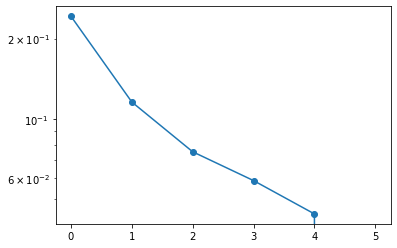

In [14]:
plt.semilogy(info['Ss'], '-o')

In [16]:
mps_overlap(out, Psi)

0.9922940916006424